# Defining the scope of our simulation

## Context
In decentralized cloud computing environments, ensuring fair and efficient interactions is difficult due to limited visibility into the individual behavior of each actor involved in a task. Traditional mechanisms struggle to handle task failures effectively, because we usually don't know which actor is responsible for task failures. Therefore there is no way to incentivize good behaviour and reliability.

To solve this problem, we introduce "Blind Slashing," a penalty system that affects all parties involved in task failures, incentivizing better behavior and enhancing system reliability. This system is inspired by collective punishement and incentivize for cooperation. It is hoped that faulty actors will be engaged in more failed transactions, thus getting ruined out of the system.

## Core elements of the Simulation:  
A list of n actors, with each actor having:  
* An initial stake S0  

A list of faulty sets of actors, with each set having:  
* Between 1 and n actors.
* A probability of failure. 

## Task process

```
@startuml
title Task Execution Flow

start

:Pick a random set of 2 to n actors;

:Find all subsets of the chosen actors that exist in the faulty sets;

while (Faulty subsets remain?) is (Yes)
  :Check if the subset is triggering failure this execution\n(Draw x, a random number between 0 and 1 and\n compare it to the subset failure probability P_fail);
  
  if (N < P_fail?) then (Yes)
    :Task is a failure;
    :Slash all actors in the set;
    stop
  else (No)
    :Continue checking remaining subsets;
  endif
endwhile

:Task is a success;
:Reward all actors in the set;

stop
@enduml
```

## Simulation process

* We execute N number of tasks.
* Actors are removed from the system when their stake reach 0.
* New actors are added regularly, we also add them to the faulty set list, for each, we pick a random P_fail using normal distribution of fault probabilities.
* For each new actor we pick a random number of faulty combination and add them to the faulty set too, for those, we also pick a random P_fail using normal distribution of fault probabilities.

## Result to observe
* Average number of successed and failed task and ratio.
* Evolution of the number of user in the system and evolution of the average user failure rate.
* Global evolution of the system failure rate (average task failure rate).

## Code
### Importing libraries

In [224]:
import random
import numpy as np
from scipy.stats import pareto
import matplotlib.pyplot as plt
from multiprocessing import Pool

### Defining constants

In [225]:
N_ACTORS_INITIAL = 100  # Initial number of actors
N_ACTORS_TASK = 4  # Number of maximum actors for each task
S0 = 1608  # Initial capital of each actor
N_TASKS = 10000  # Number of tasks to simulate
SLASH_AMOUNT = 400  # Amount slashed for failed tasks
REWARD_AMOUNT = 100  # Reward for successful tasks
NEW_ACTOR_INTERVAL = 50  # Frequency of new actor addition (in tasks)
NEW_ACTOR_FAULTY_COMBOS = 0  # Number of faulty combinations per new actor
MONTE_CARLO_RUNS = 50  # Number of Monte Carlo simulations

# Display
X_MAX = 0.50
Y_MAX = (N_ACTORS_INITIAL + N_TASKS//NEW_ACTOR_INTERVAL) // 10

### Testing different failure rate distribution

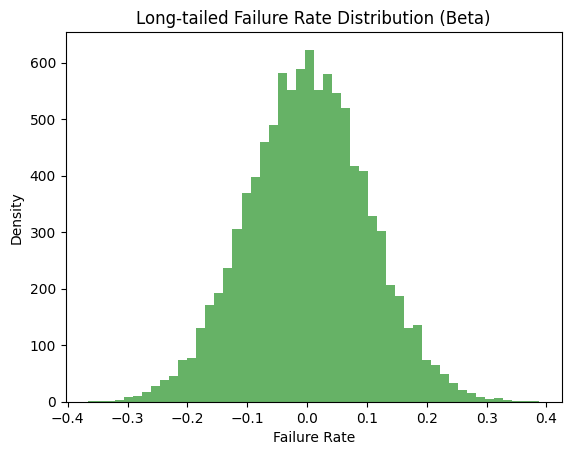

In [226]:
# Testing normal distribution ------------------------------------------
# Using a normal distribution with mean 0.18 (average failure rate) and a small std dev of 0.05
mu, sigma = 0.0, 0.10
p_fail_distribution = np.random.normal(mu, sigma, 10000)


# Testing log normal distribution --------------------------------------
# p_fail_distribution = np.random.lognormal(-1, 2, 10000)

# Testing exponential distribution -------------------------------------
# Using an exponential distribution with lambda parameter (rate of failure occurrence)
lambda_exponential = 1.0 / 6.0  # Mean time between failures (inverse of average failure rate)
# p_fail_distribution = np.random.exponential(lambda_exponential, 10000)

# Testing poisson distribution -----------------------------------------
# Using a Poisson distribution with lambda parameter (average rate of occurrence of failures)
# Poisson distribution is a discrete distribution, so we can't use it directly for failure rates
# lambda_poisson = 0.18  # Average actor failure rate
# p_fail_distribution = np.random.poisson(lambda_poisson, 10000)

# Testing pareto distribution ------------------------------------------
# Using a Pareto distribution with shape parameter `b=2` (the smaller the shape, the heavier the tail)
b = 0.5
scale = 0.001  # Set scale to reflect the typical range of values around the failure rate
# p_fail_distribution = pareto.rvs(b, scale=scale, size=10000)

# Testing continuous distribution ----------------------------------
# p_fail_distribution = [i/10000.0 for i in range(5000)]
# It seems that for a continuous distribution going from 0 to 0.3605 is the tipping point to ruining everyone
# This correspond to an average actor failure rate of 0.18025
# We notice that almost all actors are being evicted from the system at around task 600, until there is only 4 actors left. 
# It seems that if one of those actors is faulty, the system never recovers, but if we reach that point with only reliable actors, 
# then the system progressively recovers and then grows up to new highs.

# Testing binary distribution (0 or 1) ------------------------------
# p_fail_distribution = [0 for _ in range(1000)] + [1 for _ in range(1000)]
# We try to get the same average failure rate as the continuous distribution, but with a binary distribution
# Not the same behaviour, tt seem that the average actor failure rate is not the most important factor ?

# Plotting test distribution
plt.hist(p_fail_distribution, bins=50, density=False, alpha=0.6, color='g')
plt.title("Long-tailed Failure Rate Distribution (Beta)")
plt.xlabel("Failure Rate")
plt.ylabel("Density")
plt.show()

### Executing one simulation

In [227]:
# Initialize actors and faulty sets
class Actor:
    def __init__(self, id, stake):
        self.id = id
        self.stake = stake
        self.failure_rate = 0
        self.loss = 0
        self.reward = 0
        self.nb_tasks = 0

class FaultySet:
    def __init__(self, actors, p_fail):
        self.actors = actors
        self.p_fail = p_fail

# Add an actor with a faulty set
def add_actor(actors, faulty_sets):
    # Add a new actor
    new_actor = Actor(len(actors), S0)
    actors.append(new_actor)

    # Generate a faulty set for the new actor
    faulty_set = FaultySet([new_actor], generate_p_fail())
    faulty_sets.append(faulty_set)
    new_actor.failure_rate = faulty_set.p_fail
    
    # Generate faulty combinations sets for the new actor
    generate_faulty_combinations(new_actor, actors, faulty_sets)

# Generate initial faulty sets
def generate_faulty_combinations(actor, actors, faulty_sets):
    for _ in range(NEW_ACTOR_FAULTY_COMBOS):
        subset_size = random.randint(2, N_ACTORS_TASK-1)
        subset = random.sample(actors, subset_size)
        subset.append(actor)
        p_fail = generate_p_fail()
        faulty_sets.append(FaultySet(subset, p_fail))

# Generate p_fail based on long tail distribution
def generate_p_fail():
    p_fail = np.random.choice(p_fail_distribution)
    while p_fail < 0 or p_fail > 1:
        p_fail = np.random.choice(p_fail_distribution)
    # return max(0, min(1, np.random.choice(p_fail_distribution)))
    return p_fail

# Initialize actors and faulty sets
actors = [Actor(i, S0) for i in range(N_ACTORS_INITIAL)]
faulty_sets = [FaultySet([actor], generate_p_fail()) for actor in actors]
# Generate faulty combinations for the initial actors
for actor in actors:
    generate_faulty_combinations(actor, actors, faulty_sets)

# Plot the distribution of p_fail
p_fail_values = [faulty_set.p_fail for faulty_set in faulty_sets]
initial_p_fail_values = p_fail_values.copy()

# Calculate the failure rate target
failure_rate_target = REWARD_AMOUNT / (REWARD_AMOUNT + SLASH_AMOUNT)
indivudal_failure_rate_target = 1 - (1 - failure_rate_target) ** (1 / N_ACTORS_TASK)

# Calculate total number of actors that were added in the system
total_actors = N_ACTORS_INITIAL + N_TASKS // NEW_ACTOR_INTERVAL

# Task simulation
successful_tasks = 0
failed_tasks = 0

# Calculate precision, accuracy, and recall
true_positive = 0
false_positive = 0
false_negative = 0

system_failure_rates = []
actor_counts = []
average_failure_rates = []

for task_id in range(1, N_TASKS + 1):
    if len(actors) < 4:
        break
    
    # Pick a random subset of actors for the task
    task_actors = random.sample(actors, random.randint(2, N_ACTORS_TASK))
    
    # Check for faulty subsets within the chosen actors
    task_failed = False
    for faulty_set in faulty_sets:
        # Find if faulty set is a subset of task_actors
        if set(faulty_set.actors).issubset(task_actors):
            # Random chance to see if this faulty set triggers a failure
            if random.random() < faulty_set.p_fail:
                # Task failed, slash all actors involved
                task_failed = True
                failed_tasks += 1
                for actor in task_actors:
                    actor.stake -= SLASH_AMOUNT
                break

    if not task_failed:
        # Task succeeded, reward all actors involved
        successful_tasks += 1
        for actor in task_actors:
            actor.stake += REWARD_AMOUNT
    
    # Remove actors and corresponding faulty sets with zero or negative stake
    removed_actors = [actor for actor in actors if actor.stake <= 0]
    for actor in removed_actors:
        removed_failure_rate = [fs.p_fail for fs in faulty_sets if actor in fs.actors and len(fs.actors) == 1]
        # print(f'Actor {actor.id}, p_fail {removed_failure_rate} has been removed')
        if removed_failure_rate[0] > indivudal_failure_rate_target:
            true_positive += 1
        else:
            false_positive += 1
        actors.remove(actor)
    faulty_sets = [fs for fs in faulty_sets if all(actor in actors for actor in fs.actors)]

    # Every few tasks, add a new actor and corresponding faulty sets
    if task_id % NEW_ACTOR_INTERVAL == 0:
        add_actor(actors, faulty_sets)
    
    # Track system evolution metrics
    system_failure_rate = failed_tasks / task_id
    average_failure_rate = np.mean([fs.p_fail for fs in faulty_sets])
    
    system_failure_rates.append(system_failure_rate)
    average_failure_rates.append(average_failure_rate)
    actor_counts.append(len(actors))

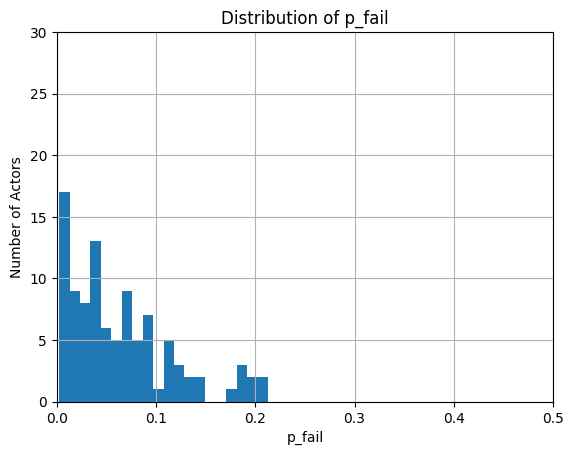

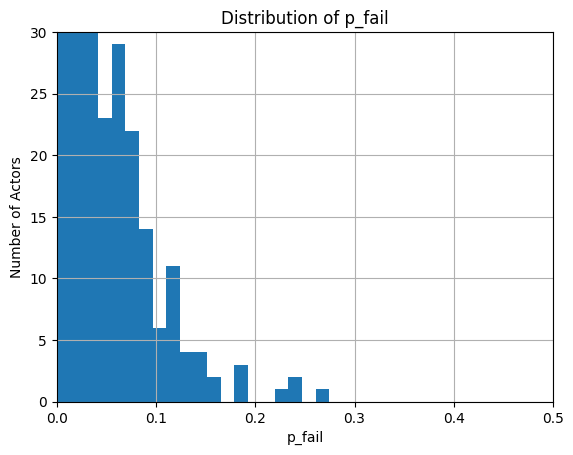

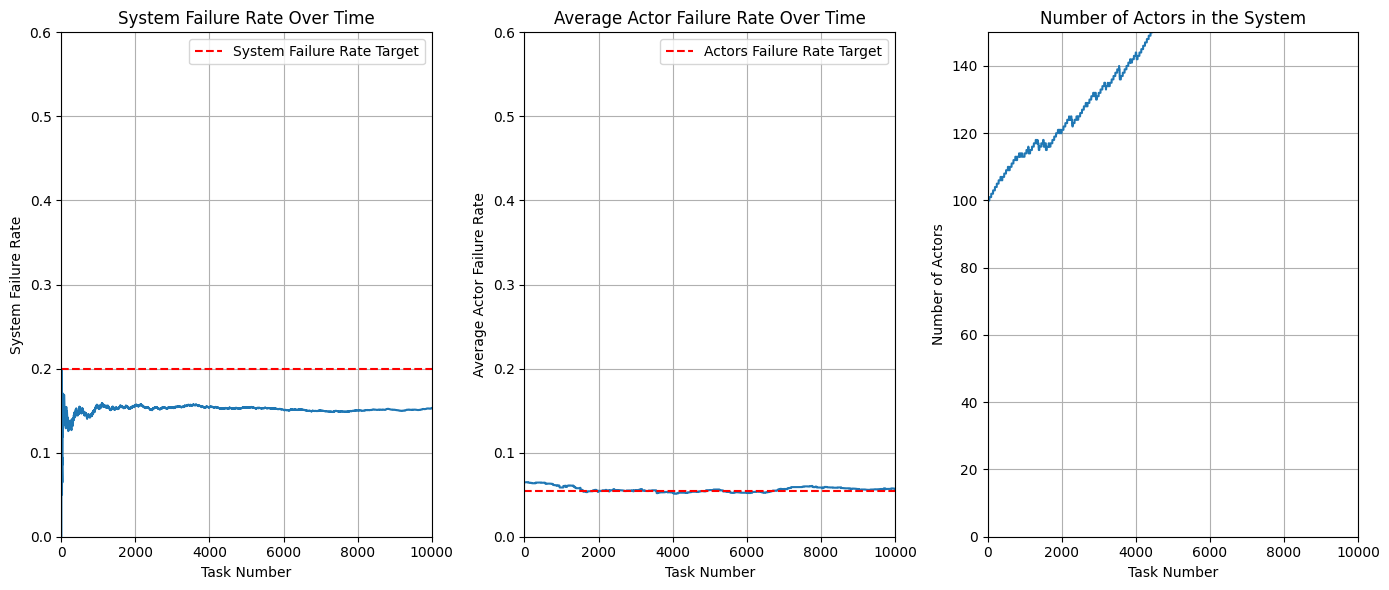

Failure rate target: 0.2
Individual failure rate target: 0.05425839099682417
Total successful tasks: 8472
Total failed tasks: 1528
Total number of actors: 300
Final number of actors: 228

Classification Metrics:
Accuracy: 0.6466666666666666
Precision: 0.9305555555555556
Recall: 0.39880952380952384


In [228]:
# Plot the distribution of p_fail
# before
plt.hist(p_fail_values, bins=20)
plt.xlabel('p_fail')
plt.ylabel('Number of Actors')
plt.title('Distribution of p_fail')
plt.xlim(0, X_MAX)  # Set the same x-axis range
plt.ylim(0, Y_MAX)      # Set the same y-axis range
plt.grid()
plt.show()

# after
p_fail_values = [faulty_set.p_fail for faulty_set in faulty_sets]
plt.hist(p_fail_values, bins=20)
plt.xlabel('p_fail')
plt.ylabel('Number of Actors')
plt.title('Distribution of p_fail')
plt.xlim(0, X_MAX)  # Set the same x-axis range
plt.ylim(0, Y_MAX)      # Set the same y-axis range
plt.grid()
plt.show()

# Plot results
plt.figure(figsize=(14, 6))

# Plot system failure rate over time
plt.subplot(1, 3, 1)
plt.plot(system_failure_rates)
plt.xlabel('Task Number')
plt.ylabel('System Failure Rate')
plt.title('System Failure Rate Over Time')
plt.xlim(0, N_TASKS)
plt.ylim(0, 0.6)
# Add horizontal line for failure rate target
plt.axhline(y=failure_rate_target, color='r', linestyle='--', label='System Failure Rate Target')
plt.legend()
plt.grid()

# Plot average actor failure rate over time
plt.subplot(1, 3, 2)
plt.plot(average_failure_rates)
plt.xlabel('Task Number')
plt.ylabel('Average Actor Failure Rate')
plt.title('Average Actor Failure Rate Over Time')
plt.xlim(0, N_TASKS)
plt.ylim(0, 0.6)
# Add horizontal line for individual actors failure rate target
plt.axhline(y=indivudal_failure_rate_target, color='r', linestyle='--', label='Actors Failure Rate Target')
plt.legend()
plt.grid()

# Plot the number of actors in the system over time
plt.subplot(1, 3, 3)
plt.plot(actor_counts)
plt.xlabel('Task Number')
plt.ylabel('Number of Actors')
plt.title('Number of Actors in the System')
plt.xlim(0, N_TASKS)
plt.ylim(0, (N_ACTORS_INITIAL + N_TASKS // NEW_ACTOR_INTERVAL) // 2)
plt.grid()

plt.tight_layout()
plt.show()

# Final results
print(f'Failure rate target: {failure_rate_target}')
print(f'Individual failure rate target: {indivudal_failure_rate_target}')
print(f'Total successful tasks: {successful_tasks}')
print(f'Total failed tasks: {failed_tasks}')
print(f'Total number of actors: {total_actors}')
print(f'Final number of actors: {len(actors)}')

# Calculate precision, accuracy, and recall
for faulty_set in faulty_sets:
    if len(faulty_set.actors) == 1 and faulty_set.p_fail > indivudal_failure_rate_target:
        false_negative += 1

precision = 0
if true_positive + false_positive != 0:
    precision = true_positive / (true_positive + false_positive)
accuracy = (true_positive + (len(actors) - false_negative)) / total_actors
recall = 0
if true_positive + false_negative != 0:
    recall = true_positive / (true_positive + false_negative)
# Display precision, accuracy, and recall
print("\nClassification Metrics:")
# Accuracy measures the proportion of correct predictions (both true positives and true negatives) among all predictions. An accuracy of 0.3 indicates that only 30% of the predictions were correct.
print(f'Accuracy: {accuracy}')
# Precision measures how many of the positively predicted cases were actually correct. A precision of 0.857 means that 85.7% of the positive predictions were true positives.
print(f'Precision: {precision}')
# Recall measures how many of the actual positive cases were correctly identified. A recall of 0.978 means that 97.8% of actual positives were predicted as positive.
print(f'Recall: {recall}')

### Analysing downward and upward part separately

In [229]:
# Initialize actors and faulty sets
actors = [Actor(i, S0) for i in range(N_ACTORS_INITIAL)]
faulty_sets = [FaultySet([actor], generate_p_fail()) for actor in actors]
# Generate faulty combinations for the initial actors
for actor in actors:
    generate_faulty_combinations(actor, actors, faulty_sets)

# Plot the distribution of p_fail
p_fail_values = [faulty_set.p_fail for faulty_set in faulty_sets]
initial_p_fail_values = p_fail_values.copy()

# Calculate the failure rate target
failure_rate_target = REWARD_AMOUNT / (REWARD_AMOUNT + SLASH_AMOUNT)
indivudal_failure_rate_target = 1 - (1 - failure_rate_target) ** (1 / N_ACTORS_TASK)

# Calculate total number of actors that were added in the system
total_actors = N_ACTORS_INITIAL

# Task simulation
successful_tasks = 0
failed_tasks = 0

# Calculate precision, accuracy, and recall
true_positive = 0
false_positive = 0
false_negative = 0

system_failure_rates = []
actor_counts = []
average_failure_rates = []

for task_id in range(1, N_TASKS + 1):
    if len(actors) < 4:
        break
    
    # Pick a random subset of actors for the task
    task_actors = random.sample(actors, random.randint(2, N_ACTORS_TASK))
    
    # Check for faulty subsets within the chosen actors
    task_failed = False
    for faulty_set in faulty_sets:
        # Find if faulty set is a subset of task_actors
        if set(faulty_set.actors).issubset(task_actors):
            # Random chance to see if this faulty set triggers a failure
            if random.random() < faulty_set.p_fail:
                # Task failed, slash all actors involved
                task_failed = True
                failed_tasks += 1
                for actor in task_actors:
                    actor.stake -= SLASH_AMOUNT
                break

    if not task_failed:
        # Task succeeded, reward all actors involved
        successful_tasks += 1
        for actor in task_actors:
            actor.stake += REWARD_AMOUNT
    
    # Remove actors and corresponding faulty sets with zero or negative stake
    removed_actors = [actor for actor in actors if actor.stake <= 0]
    for actor in removed_actors:
        removed_failure_rate = [fs.p_fail for fs in faulty_sets if actor in fs.actors and len(fs.actors) == 1]
        # print(f'Actor {actor.id}, p_fail {removed_failure_rate} has been removed')
        if removed_failure_rate[0] > indivudal_failure_rate_target:
            true_positive += 1
        else:
            false_positive += 1
        actors.remove(actor)
    faulty_sets = [fs for fs in faulty_sets if all(actor in actors for actor in fs.actors)]

    # Every few tasks, add a new actor and corresponding faulty sets
    if task_id % NEW_ACTOR_INTERVAL == 0:
        add_actor(actors, faulty_sets)
        total_actors += 1
    
    # Track system evolution metrics
    system_failure_rate = failed_tasks / task_id
    average_failure_rate = np.mean([fs.p_fail for fs in faulty_sets])
    
    system_failure_rates.append(system_failure_rate)
    average_failure_rates.append(average_failure_rate)
    actor_counts.append(len(actors))

    # Print stats around task 2000
    if task_id == 1500:
        print(f'\n--- Stats at Task {task_id} ---')
        print(f'Total successful tasks: {successful_tasks}')
        print(f'Total failed tasks: {failed_tasks}')
        print(f'Total number of actors: {total_actors}')
        print(f'Current number of actors: {len(actors)}')
        print(f'Ratio of ruined actors: {(total_actors - len(actors)) / total_actors * 100}%')

        # Calculate precision, accuracy, and recall
        for faulty_set in faulty_sets:
            if len(faulty_set.actors) == 1 and faulty_set.p_fail > indivudal_failure_rate_target:
                false_negative += 1

        precision = 0
        if true_positive + false_positive != 0:
            precision = true_positive / (true_positive + false_positive)
        accuracy = (true_positive + (len(actors) - false_negative)) / total_actors
        recall = 0
        if true_positive + false_negative != 0:
            recall = true_positive / (true_positive + false_negative)
        # Display precision, accuracy, and recall
        print("\nClassification Metrics:")
        print(f'Accuracy: {accuracy}')
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')



--- Stats at Task 1500 ---
Total successful tasks: 1214
Total failed tasks: 286
Total number of actors: 130
Current number of actors: 92
Ratio of ruined actors: 29.230769230769234%

Classification Metrics:
Accuracy: 0.676923076923077
Precision: 0.8947368421052632
Recall: 0.4722222222222222


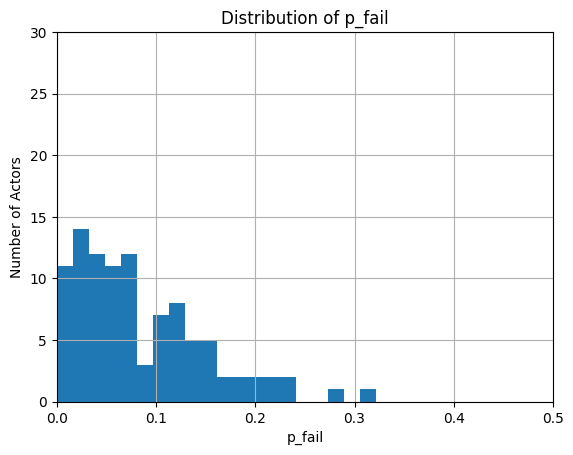

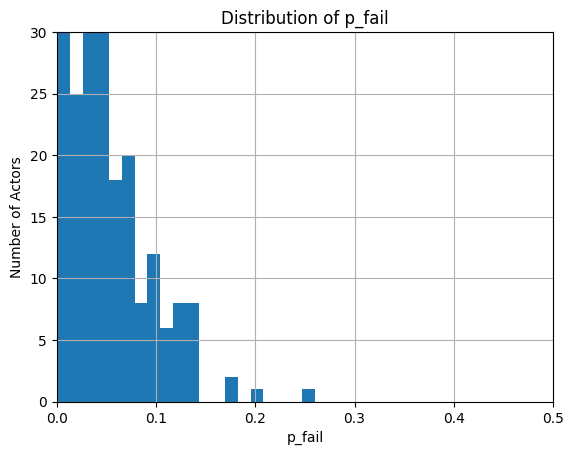

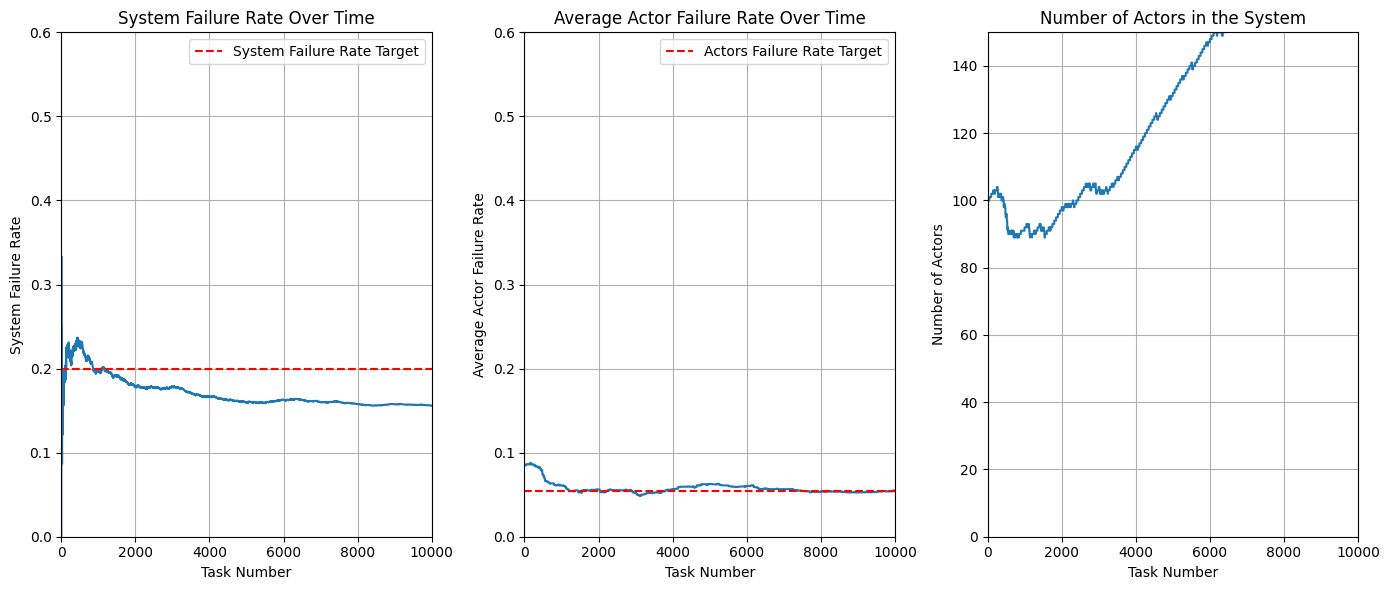


--- Final Stats ---
Total successful tasks: 8442
Total failed tasks: 1558
Total number of actors: 300
Final number of actors: 202
Ratio of ruined actors: 32.666666666666664%

Classification Metrics:
Accuracy: 0.56
Precision: 0.8877551020408163
Recall: 0.4182692307692308


In [230]:
# Plot the distribution of p_fail
# before
plt.hist(p_fail_values, bins=20)
plt.xlabel('p_fail')
plt.ylabel('Number of Actors')
plt.title('Distribution of p_fail')
plt.xlim(0, X_MAX)  # Set the same x-axis range
plt.ylim(0, Y_MAX)      # Set the same y-axis range
plt.grid()
plt.show()

# after
p_fail_values = [faulty_set.p_fail for faulty_set in faulty_sets]
plt.hist(p_fail_values, bins=20)
plt.xlabel('p_fail')
plt.ylabel('Number of Actors')
plt.title('Distribution of p_fail')
plt.xlim(0, X_MAX)  # Set the same x-axis range
plt.ylim(0, Y_MAX)      # Set the same y-axis range
plt.grid()
plt.show()

# Plot results
plt.figure(figsize=(14, 6))

# Plot system failure rate over time
plt.subplot(1, 3, 1)
plt.plot(system_failure_rates)
plt.xlabel('Task Number')
plt.ylabel('System Failure Rate')
plt.title('System Failure Rate Over Time')
plt.xlim(0, N_TASKS)
plt.ylim(0, 0.6)
# Add horizontal line for failure rate target
plt.axhline(y=failure_rate_target, color='r', linestyle='--', label='System Failure Rate Target')
plt.legend()
plt.grid()

# Plot average actor failure rate over time
plt.subplot(1, 3, 2)
plt.plot(average_failure_rates)
plt.xlabel('Task Number')
plt.ylabel('Average Actor Failure Rate')
plt.title('Average Actor Failure Rate Over Time')
plt.xlim(0, N_TASKS)
plt.ylim(0, 0.6)
# Add horizontal line for individual actors failure rate target
plt.axhline(y=indivudal_failure_rate_target, color='r', linestyle='--', label='Actors Failure Rate Target')
plt.legend()
plt.grid()

# Plot the number of actors in the system over time
plt.subplot(1, 3, 3)
plt.plot(actor_counts)
plt.xlabel('Task Number')
plt.ylabel('Number of Actors')
plt.title('Number of Actors in the System')
plt.xlim(0, N_TASKS)
plt.ylim(0, (N_ACTORS_INITIAL + N_TASKS // NEW_ACTOR_INTERVAL) // 2)
plt.grid()

plt.tight_layout()
plt.show()

# Final results
print(f'\n--- Final Stats ---')
print(f'Total successful tasks: {successful_tasks}')
print(f'Total failed tasks: {failed_tasks}')
print(f'Total number of actors: {total_actors}')
print(f'Final number of actors: {len(actors)}')
print(f'Ratio of ruined actors: {(total_actors - len(actors)) / total_actors * 100}%')

# Calculate precision, accuracy, and recall
for faulty_set in faulty_sets:
    if len(faulty_set.actors) == 1 and faulty_set.p_fail > indivudal_failure_rate_target:
        false_negative += 1

precision = 0
if true_positive + false_positive != 0:
    precision = true_positive / (true_positive + false_positive)
accuracy = (true_positive + (len(actors) - false_negative)) / total_actors
recall = 0
if true_positive + false_negative != 0:
    recall = true_positive / (true_positive + false_negative)
# Display precision, accuracy, and recall
print("\nClassification Metrics:")
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

We indeed notice that the very first portion has a very low accuracy and that it builds up once most actors have been cleared from the system. This is not very desirable and is indeed unfair for the early actors in the system.

### Starting simulation from 0 actors

In [234]:
N_ACTORS_INITIAL = 10  # Initial number of actors
N_ACTORS_TASK = 4  # Number of maximum actors for each task
S0 = 1608  # Initial capital of each actor
N_TASKS = 10000  # Number of tasks to simulate
SLASH_AMOUNT = 400  # Amount slashed for failed tasks
REWARD_AMOUNT = 100  # Reward for successful tasks
NEW_ACTOR_INTERVAL = 50  # Frequency of new actor addition (in tasks)
NEW_ACTOR_FAULTY_COMBOS = 0  # Number of faulty combinations per new actor
MONTE_CARLO_RUNS = 50  # Number of Monte Carlo simulations

# Initialize actors and faulty sets
actors = [Actor(i, S0) for i in range(N_ACTORS_INITIAL)]
faulty_sets = [FaultySet([actor], generate_p_fail()) for actor in actors]
# Generate faulty combinations for the initial actors
for actor in actors:
    generate_faulty_combinations(actor, actors, faulty_sets)

# Plot the distribution of p_fail
p_fail_values = [faulty_set.p_fail for faulty_set in faulty_sets]
initial_p_fail_values = p_fail_values.copy()

# Calculate the failure rate target
failure_rate_target = REWARD_AMOUNT / (REWARD_AMOUNT + SLASH_AMOUNT)
indivudal_failure_rate_target = 1 - (1 - failure_rate_target) ** (1 / N_ACTORS_TASK)

# Calculate total number of actors that were added in the system
total_actors = N_ACTORS_INITIAL

# Task simulation
successful_tasks = 0
failed_tasks = 0

# Calculate precision, accuracy, and recall
true_positive = 0
false_positive = 0
false_negative = 0

system_failure_rates = []
actor_counts = []
average_failure_rates = []

for task_id in range(1, N_TASKS + 1):
    if len(actors) < 4:
        break
    
    # Pick a random subset of actors for the task
    task_actors = random.sample(actors, random.randint(2, N_ACTORS_TASK))
    
    # Check for faulty subsets within the chosen actors
    task_failed = False
    for faulty_set in faulty_sets:
        # Find if faulty set is a subset of task_actors
        if set(faulty_set.actors).issubset(task_actors):
            # Random chance to see if this faulty set triggers a failure
            if random.random() < faulty_set.p_fail:
                # Task failed, slash all actors involved
                task_failed = True
                failed_tasks += 1
                for actor in task_actors:
                    actor.stake -= SLASH_AMOUNT
                break

    if not task_failed:
        # Task succeeded, reward all actors involved
        successful_tasks += 1
        for actor in task_actors:
            actor.stake += REWARD_AMOUNT
    
    # Remove actors and corresponding faulty sets with zero or negative stake
    removed_actors = [actor for actor in actors if actor.stake <= 0]
    for actor in removed_actors:
        removed_failure_rate = [fs.p_fail for fs in faulty_sets if actor in fs.actors and len(fs.actors) == 1]
        # print(f'Actor {actor.id}, p_fail {removed_failure_rate} has been removed')
        if removed_failure_rate[0] > indivudal_failure_rate_target:
            true_positive += 1
        else:
            false_positive += 1
        actors.remove(actor)
    faulty_sets = [fs for fs in faulty_sets if all(actor in actors for actor in fs.actors)]

    # Every few tasks, add a new actor and corresponding faulty sets
    if task_id % NEW_ACTOR_INTERVAL == 0:
        add_actor(actors, faulty_sets)
        total_actors += 1
    
    # Track system evolution metrics
    system_failure_rate = failed_tasks / task_id
    average_failure_rate = np.mean([fs.p_fail for fs in faulty_sets])
    
    system_failure_rates.append(system_failure_rate)
    average_failure_rates.append(average_failure_rate)
    actor_counts.append(len(actors))

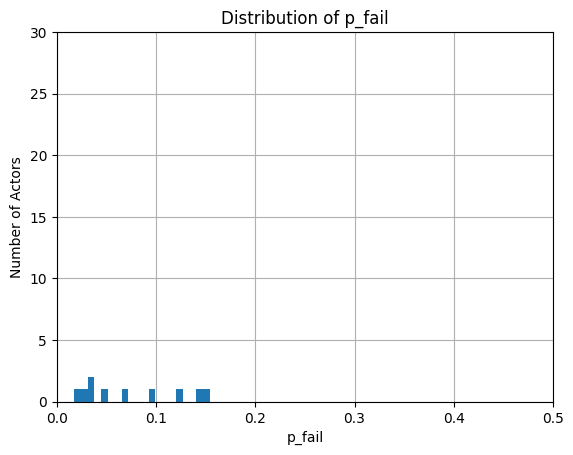

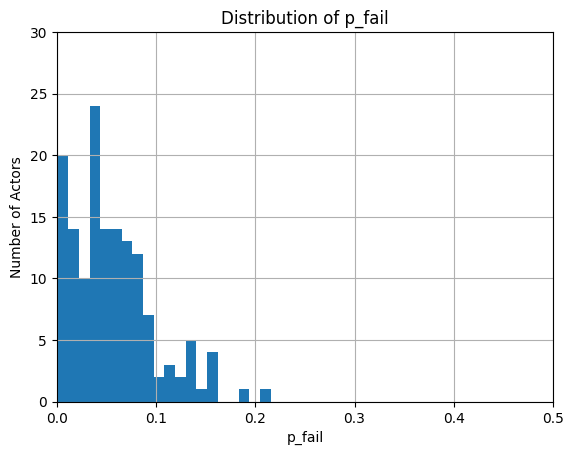

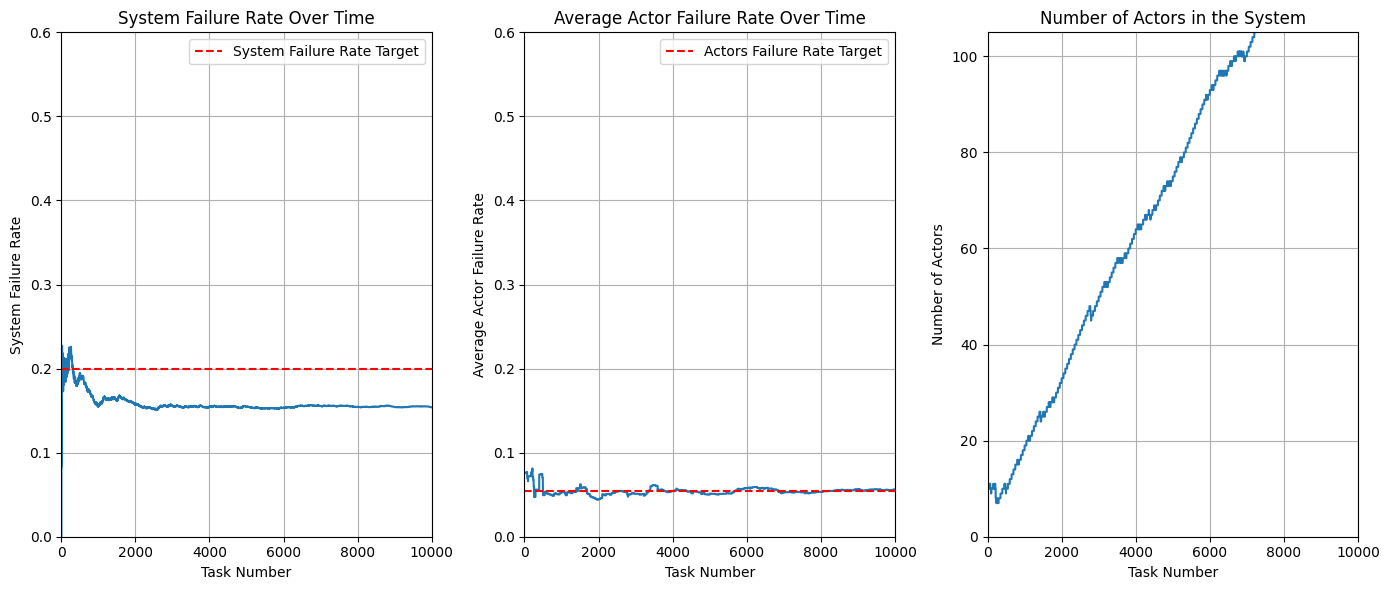


--- Final Stats ---
Failure rate target: 0.2
Individual failure rate target: 0.05425839099682417
Total successful tasks: 8461
Total failed tasks: 1539
Total number of actors: 210
Final number of actors: 147

Classification Metrics:
Accuracy: 0.6428571428571429
Precision: 0.8412698412698413
Recall: 0.4491525423728814


In [235]:
# Plot the distribution of p_fail
# before
plt.hist(p_fail_values, bins=20)
plt.xlabel('p_fail')
plt.ylabel('Number of Actors')
plt.title('Distribution of p_fail')
plt.xlim(0, X_MAX)  # Set the same x-axis range
plt.ylim(0, Y_MAX)      # Set the same y-axis range
plt.grid()
plt.show()

# after
p_fail_values = [faulty_set.p_fail for faulty_set in faulty_sets]
plt.hist(p_fail_values, bins=20)
plt.xlabel('p_fail')
plt.ylabel('Number of Actors')
plt.title('Distribution of p_fail')
plt.xlim(0, X_MAX)  # Set the same x-axis range
plt.ylim(0, Y_MAX)      # Set the same y-axis range
plt.grid()
plt.show()

# Plot results
plt.figure(figsize=(14, 6))

# Plot system failure rate over time
plt.subplot(1, 3, 1)
plt.plot(system_failure_rates)
plt.xlabel('Task Number')
plt.ylabel('System Failure Rate')
plt.title('System Failure Rate Over Time')
plt.xlim(0, N_TASKS)
plt.ylim(0, 0.6)
# Add horizontal line for failure rate target
plt.axhline(y=failure_rate_target, color='r', linestyle='--', label='System Failure Rate Target')
plt.legend()
plt.grid()

# Plot average actor failure rate over time
plt.subplot(1, 3, 2)
plt.plot(average_failure_rates)
plt.xlabel('Task Number')
plt.ylabel('Average Actor Failure Rate')
plt.title('Average Actor Failure Rate Over Time')
plt.xlim(0, N_TASKS)
plt.ylim(0, 0.6)
# Add horizontal line for individual actors failure rate target
plt.axhline(y=indivudal_failure_rate_target, color='r', linestyle='--', label='Actors Failure Rate Target')
plt.legend()
plt.grid()

# Plot the number of actors in the system over time
plt.subplot(1, 3, 3)
plt.plot(actor_counts)
plt.xlabel('Task Number')
plt.ylabel('Number of Actors')
plt.title('Number of Actors in the System')
plt.xlim(0, N_TASKS)
plt.ylim(0, (N_ACTORS_INITIAL + N_TASKS // NEW_ACTOR_INTERVAL) // 2)
plt.grid()

plt.tight_layout()
plt.show()

# Final results
print(f'\n--- Final Stats ---')
print(f'Failure rate target: {failure_rate_target}')
print(f'Individual failure rate target: {indivudal_failure_rate_target}')
print(f'Total successful tasks: {successful_tasks}')
print(f'Total failed tasks: {failed_tasks}')
print(f'Total number of actors: {total_actors}')
print(f'Final number of actors: {len(actors)}')

# Calculate precision, accuracy, and recall
for faulty_set in faulty_sets:
    if len(faulty_set.actors) == 1 and faulty_set.p_fail > indivudal_failure_rate_target:
        false_negative += 1

precision = 0
if true_positive + false_positive != 0:
    precision = true_positive / (true_positive + false_positive)
accuracy = (true_positive + (len(actors) - false_negative)) / total_actors
recall = 0
if true_positive + false_negative != 0:
    recall = true_positive / (true_positive + false_negative)
# Display precision, accuracy, and recall
print("\nClassification Metrics:")
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

We notice no purge of actors, but looking closely at the final number of actors vs the overall number of actors, more than 50% of actors were slayed, which is a lot.

### Trying with way smaller and more credible failure rate

First looking at practical basis for the average reliability of an user/application...: ?

### Executing several simulations (Monte Carlo)

To implement a Monte Carlo simulation, we need to run the same simulation multiple times and aggregate the results. This will give us a broader view of how the system behaves across different random scenarios. I'll modify the code to add a Monte Carlo loop, store the outcomes of each simulation, and then calculate the average metrics across all simulations.

In [233]:
# Monte Carlo results storage
monte_carlo_results = {
    'system_failure_rates': [],
    'average_failure_rates': [],
    'actor_counts': [],
    'final_successful_tasks': [],
    'final_failed_tasks': [],
    'final_number_of_actors': [],
    'precisions': [],
    'accuracies': [],
    'recalls': []
}

# Function to pad a list with zeros up to a target length
def pad_list_with_zeros(lst, target_length):
    return lst + [0] * (target_length - len(lst))

# Function extend list to desired length by repeatinig the last element
def extend_list(lst, target_length):
    return lst + [lst[-1]] * (target_length - len(lst))

# Function to run a single simulation
def run_simulation():
    # Initialize actors and faulty sets
    actors = [Actor(i, S0) for i in range(N_ACTORS_INITIAL)]
    faulty_sets = [FaultySet([actor], generate_p_fail()) for actor in actors]

    # Generate faulty combinations for the initial actors
    for actor in actors:
        generate_faulty_combinations(actor, actors, faulty_sets)

    successful_tasks = 0
    failed_tasks = 0
    true_positive = 0
    false_positive = 0
    false_negative = 0

    system_failure_rates = []
    actor_counts = []
    average_failure_rates = []

    # Task simulation loop
    for task_id in range(1, N_TASKS + 1):
        if len(actors) < 4:
            break
        
        # Pick a random subset of actors for the task
        task_actors = random.sample(actors, random.randint(2, N_ACTORS_TASK))
        
        # Check for faulty subsets within the chosen actors
        task_failed = False
        for faulty_set in faulty_sets:
            # Find if faulty set is a subset of task_actors
            if set(faulty_set.actors).issubset(task_actors):
                # Random chance to see if this faulty set triggers a failure
                if random.random() < faulty_set.p_fail:
                    # Task failed, slash all actors involved
                    task_failed = True
                    failed_tasks += 1
                    for actor in task_actors:
                        actor.stake -= SLASH_AMOUNT
                    break

        if not task_failed:
            # Task succeeded, reward all actors involved
            successful_tasks += 1
            for actor in task_actors:
                actor.stake += REWARD_AMOUNT
        
        # Remove actors and corresponding faulty sets with zero or negative stake
        removed_actors = [actor for actor in actors if actor.stake <= 0]
        for actor in removed_actors:
            removed_failure_rate = [fs.p_fail for fs in faulty_sets if actor in fs.actors and len(fs.actors) == 1]
            if removed_failure_rate and removed_failure_rate[0] > indivudal_failure_rate_target:
                true_positive += 1
            else:
                false_positive += 1
            actors.remove(actor)
        faulty_sets = [fs for fs in faulty_sets if all(actor in actors for actor in fs.actors)]

        # Every few tasks, add a new actor and corresponding faulty sets
        if task_id % NEW_ACTOR_INTERVAL == 0:
            add_actor(actors, faulty_sets)
        
        # Track system evolution metrics
        system_failure_rate = failed_tasks / task_id
        average_failure_rate = np.mean([fs.p_fail for fs in faulty_sets])
        
        system_failure_rates.append(system_failure_rate)
        average_failure_rates.append(average_failure_rate)
        actor_counts.append(len(actors))
    
    # Calculate precision, accuracy, and recall
    for faulty_set in faulty_sets:
        if len(faulty_set.actors) == 1 and faulty_set.p_fail > indivudal_failure_rate_target:
            false_negative += 1

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    accuracy = (true_positive + (len(actors) - false_negative)) / total_actors if total_actors > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0

    return {
        'system_failure_rates': system_failure_rates,
        'average_failure_rates': average_failure_rates,
        'actor_counts': actor_counts,
        'successful_tasks': successful_tasks,
        'failed_tasks': failed_tasks,
        'final_number_of_actors': len(actors),
        'precision': precision,
        'accuracy': accuracy,
        'recall': recall
    }

# Run Monte Carlo simulations
for i in range(MONTE_CARLO_RUNS):
    result = run_simulation()
    monte_carlo_results['system_failure_rates'].append(result['system_failure_rates'])
    monte_carlo_results['average_failure_rates'].append(result['average_failure_rates'])
    monte_carlo_results['actor_counts'].append(result['actor_counts'])
    monte_carlo_results['final_successful_tasks'].append(result['successful_tasks'])
    monte_carlo_results['final_failed_tasks'].append(result['failed_tasks'])
    monte_carlo_results['final_number_of_actors'].append(result['final_number_of_actors'])
    monte_carlo_results['precisions'].append(result['precision'])
    monte_carlo_results['accuracies'].append(result['accuracy'])
    monte_carlo_results['recalls'].append(result['recall'])

# Count the number of uncompleted simulations
uncompleted_simulations = 0
for i in range(MONTE_CARLO_RUNS):
    if len(monte_carlo_results['system_failure_rates'][i]) < N_TASKS:
        uncompleted_simulations += 1

# Pad the lists with zeros to the maximum length
padded_system_failure_rates = [extend_list(run, N_TASKS) for run in monte_carlo_results['system_failure_rates']]
padded_average_failure_rates = [extend_list(run, N_TASKS) for run in monte_carlo_results['average_failure_rates']]
padded_actor_counts = [extend_list(run, N_TASKS) for run in monte_carlo_results['actor_counts']]

# Aggregate the results
avg_system_failure_rates = np.mean(padded_system_failure_rates, axis=0)
avg_average_failure_rates = np.mean(padded_average_failure_rates, axis=0)
avg_actor_counts = np.mean(padded_actor_counts, axis=0)

avg_final_successful_tasks = np.mean(monte_carlo_results['final_successful_tasks'])
avg_final_failed_tasks = np.mean(monte_carlo_results['final_failed_tasks'])
avg_final_number_of_actors = np.mean(monte_carlo_results['final_number_of_actors'])
avg_precision = np.mean(monte_carlo_results['precisions'])
avg_accuracy = np.mean(monte_carlo_results['accuracies'])
avg_recall = np.mean(monte_carlo_results['recalls'])

KeyboardInterrupt: 

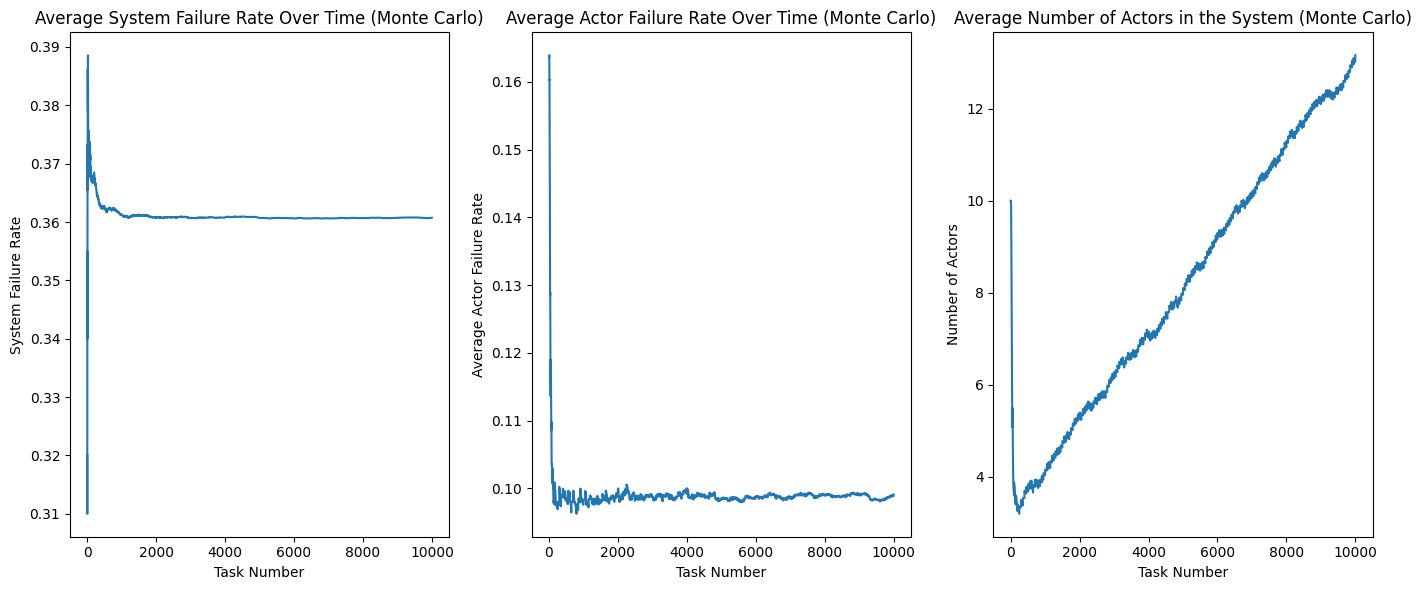

Average total successful tasks: 1208.82
Average total failed tasks: 263.26
Total number of actors: 210
Average final number of actors: 13.16
Uncompleted simulations: 43/50

Classification Metrics (Averaged over Monte Carlo runs):
Average Precision: 0.9024310442271931
Average Accuracy: 0.1476190476190476
Average Recall: 0.7931641097732234


In [200]:
# Plot aggregated results
plt.figure(figsize=(14, 6))

# Plot system failure rate over time (averaged over Monte Carlo runs)
plt.subplot(1, 3, 1)
plt.plot(avg_system_failure_rates)
plt.xlabel('Task Number')
plt.ylabel('System Failure Rate')
plt.title('Average System Failure Rate Over Time (Monte Carlo)')

# Plot average actor failure rate over time (averaged over Monte Carlo runs)
plt.subplot(1, 3, 2)
plt.plot(avg_average_failure_rates)
plt.xlabel('Task Number')
plt.ylabel('Average Actor Failure Rate')
plt.title('Average Actor Failure Rate Over Time (Monte Carlo)')

# Plot the number of actors in the system over time (averaged over Monte Carlo runs)
plt.subplot(1, 3, 3)
plt.plot(avg_actor_counts)
plt.xlabel('Task Number')
plt.ylabel('Number of Actors')
plt.title('Average Number of Actors in the System (Monte Carlo)')

plt.tight_layout()
plt.show()

# Final results
print(f'Average total successful tasks: {avg_final_successful_tasks}')
print(f'Average total failed tasks: {avg_final_failed_tasks}')
print(f'Total number of actors: {total_actors}')
print(f'Average final number of actors: {avg_final_number_of_actors}')
print(f'Uncompleted simulations: {uncompleted_simulations}/{MONTE_CARLO_RUNS}')

# Display precision, accuracy, and recall
print("\nClassification Metrics (Averaged over Monte Carlo runs):")
print(f'Average Precision: {avg_precision}')
print(f'Average Accuracy: {avg_accuracy}')
print(f'Average Recall: {avg_recall}')

# Add the ratio of failed tasks to the total number of tasks
# Find which average failure rate gives the best metrics
# Find out why it takes so long with low failure rate distributions

# Concerning simulation aborting because of everyone's ruin. It might be due to the small pool of actors with not enough actor having a low enough failure rate due to the random draw.

### Measure the average loss per actor and per task depending on individual failure rate

In [201]:

# Bins setup for failure rates
def get_failure_rate_bin(p_fail, bin_size=0.05):
    return round(min(max(p_fail, 0), 1) // bin_size * bin_size, 2)

# Function to compute average reward and loss per failure rate bin
def compute_average_reward_and_loss(actors, removed_actors, faulty_sets):
    reward_bins = {round(i * 0.05, 2): [] for i in range(20)}  # Bins of 0.05
    loss_bins = {round(i * 0.05, 2): [] for i in range(20)}    # Bins of 0.05

    # Iterate through all actors
    for actor in actors:
        if actor.nb_tasks == 0:
            continue
        
        bin_key = get_failure_rate_bin(actor.failure_rate)
        
        # Add actor's reward and loss to the corresponding bin
        reward_bins[bin_key].append(actor.reward / actor.nb_tasks)
        loss_bins[bin_key].append(actor.loss / actor.nb_tasks)

    for actor in removed_actors:
        if actor.nb_tasks == 0:
            continue

        bin_key = get_failure_rate_bin(actor.failure_rate)
        
        # Add actor's reward and loss to the corresponding bin
        reward_bins[bin_key].append(actor.reward / actor.nb_tasks)
        loss_bins[bin_key].append(actor.loss / actor.nb_tasks)

    # Compute the averages for each bin
    average_rewards_per_bin = {bin_key: np.mean(values) if values else 0 for bin_key, values in reward_bins.items()}
    average_losses_per_bin = {bin_key: np.mean(values) if values else 0 for bin_key, values in loss_bins.items()}

    return average_rewards_per_bin, average_losses_per_bin

In [202]:
# Monte Carlo results storage
monte_carlo_results = {
    'system_failure_rates': [],
    'average_failure_rates': [],
    'actor_counts': [],
    'final_successful_tasks': [],
    'final_failed_tasks': [],
    'final_number_of_actors': [],
    'precisions': [],
    'accuracies': [],
    'recalls': [],
    'actors': [],
    'removed_actors': []
}

# Function to pad a list with zeros up to a target length
def pad_list_with_zeros(lst, target_length):
    return lst + [0] * (target_length - len(lst))

# Function extend list to desired length by repeatinig the last element
def extend_list(lst, target_length):
    return lst + [lst[-1]] * (target_length - len(lst))

# Function to run a single simulation
def run_simulation():
    # Initialize actors and faulty sets
    actors = [Actor(i, S0) for i in range(N_ACTORS_INITIAL)]
    for actor in actors:
        faulty_set = FaultySet([actor], generate_p_fail())
        actor.failure_rate = faulty_set.p_fail
        faulty_sets.append(faulty_set)

    # Generate faulty combinations for the initial actors
    for actor in actors:
        generate_faulty_combinations(actor, actors, faulty_sets)

    successful_tasks = 0
    failed_tasks = 0
    true_positive = 0
    false_positive = 0
    false_negative = 0

    removed_actors = []
    system_failure_rates = []
    actor_counts = []
    average_failure_rates = []

    # Task simulation loop
    for task_id in range(1, N_TASKS + 1):
        if len(actors) < 4:
            break
        
        # Pick a random subset of actors for the task
        task_actors = random.sample(actors, random.randint(2, N_ACTORS_TASK))
        
        # Check for faulty subsets within the chosen actors
        task_failed = False
        for faulty_set in faulty_sets:
            # Find if faulty set is a subset of task_actors
            if set(faulty_set.actors).issubset(task_actors):
                # Random chance to see if this faulty set triggers a failure
                if random.random() < faulty_set.p_fail:
                    # Task failed, slash all actors involved
                    task_failed = True
                    failed_tasks += 1
                    for actor in task_actors:
                        actor.stake -= SLASH_AMOUNT
                        actor.nb_tasks += 1
                        actor.loss += SLASH_AMOUNT
                    break

        if not task_failed:
            # Task succeeded, reward all actors involved
            successful_tasks += 1
            for actor in task_actors:
                actor.stake += REWARD_AMOUNT
                actor.nb_tasks += 1
                actor.reward += REWARD_AMOUNT
        
        # Remove actors and corresponding faulty sets with zero or negative stake
        to_remove = [actor for actor in actors if actor.stake <= 0]
        removed_actors.extend(to_remove)
        for actor in to_remove:
            removed_failure_rate = [fs.p_fail for fs in faulty_sets if actor in fs.actors and len(fs.actors) == 1]
            if removed_failure_rate and removed_failure_rate[0] > indivudal_failure_rate_target:
                true_positive += 1
            else:
                false_positive += 1
            actors.remove(actor)
        # faulty_sets = [fs for fs in faulty_sets if all(actor in actors for actor in fs.actors)]

        # Every few tasks, add a new actor and corresponding faulty sets
        if task_id % NEW_ACTOR_INTERVAL == 0:
            add_actor(actors, faulty_sets)
        
        # Track system evolution metrics
        system_failure_rate = failed_tasks / task_id
        average_failure_rate = np.mean([fs.p_fail for fs in faulty_sets])
        
        system_failure_rates.append(system_failure_rate)
        average_failure_rates.append(average_failure_rate)
        actor_counts.append(len(actors))
    
    # Calculate precision, accuracy, and recall
    for faulty_set in faulty_sets:
        if len(faulty_set.actors) == 1 and faulty_set.p_fail > indivudal_failure_rate_target:
            false_negative += 1

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    accuracy = (true_positive + (len(actors) - false_negative)) / total_actors if total_actors > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0

    return {
        'system_failure_rates': system_failure_rates,
        'average_failure_rates': average_failure_rates,
        'actor_counts': actor_counts,
        'successful_tasks': successful_tasks,
        'failed_tasks': failed_tasks,
        'final_number_of_actors': len(actors),
        'precision': precision,
        'accuracy': accuracy,
        'recall': recall,
        'actors': actors,
        'removed_actors': removed_actors
    }

# Run Monte Carlo simulations
for i in range(MONTE_CARLO_RUNS):
    result = run_simulation()
    monte_carlo_results['system_failure_rates'].append(result['system_failure_rates'])
    monte_carlo_results['average_failure_rates'].append(result['average_failure_rates'])
    monte_carlo_results['actor_counts'].append(result['actor_counts'])
    monte_carlo_results['final_successful_tasks'].append(result['successful_tasks'])
    monte_carlo_results['final_failed_tasks'].append(result['failed_tasks'])
    monte_carlo_results['final_number_of_actors'].append(result['final_number_of_actors'])
    monte_carlo_results['precisions'].append(result['precision'])
    monte_carlo_results['accuracies'].append(result['accuracy'])
    monte_carlo_results['recalls'].append(result['recall'])
    monte_carlo_results['actors'].extend(result['actors'])
    monte_carlo_results['removed_actors'].extend(result['removed_actors'])

# Compute average reward and loss per failure rate bin
average_rewards_per_bin, average_losses_per_bin = compute_average_reward_and_loss(monte_carlo_results['actors'], monte_carlo_results['removed_actors'], faulty_sets)

# Count the number of uncompleted simulations
uncompleted_simulations = 0
for i in range(MONTE_CARLO_RUNS):
    if len(monte_carlo_results['system_failure_rates'][i]) < N_TASKS:
        uncompleted_simulations += 1

# Pad the lists with zeros to the maximum length
padded_system_failure_rates = [extend_list(run, N_TASKS) for run in monte_carlo_results['system_failure_rates']]
padded_average_failure_rates = [extend_list(run, N_TASKS) for run in monte_carlo_results['average_failure_rates']]
padded_actor_counts = [extend_list(run, N_TASKS) for run in monte_carlo_results['actor_counts']]

# Aggregate the results
avg_system_failure_rates = np.mean(padded_system_failure_rates, axis=0)
avg_average_failure_rates = np.mean(padded_average_failure_rates, axis=0)
avg_actor_counts = np.mean(padded_actor_counts, axis=0)

avg_final_successful_tasks = np.mean(monte_carlo_results['final_successful_tasks'])
avg_final_failed_tasks = np.mean(monte_carlo_results['final_failed_tasks'])
avg_final_number_of_actors = np.mean(monte_carlo_results['final_number_of_actors'])
avg_precision = np.mean(monte_carlo_results['precisions'])
avg_accuracy = np.mean(monte_carlo_results['accuracies'])
avg_recall = np.mean(monte_carlo_results['recalls'])

KeyboardInterrupt: 

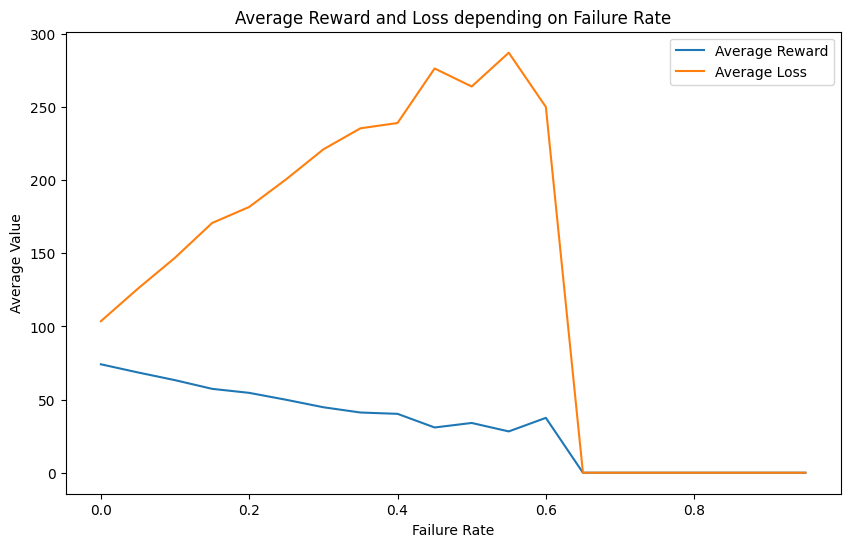

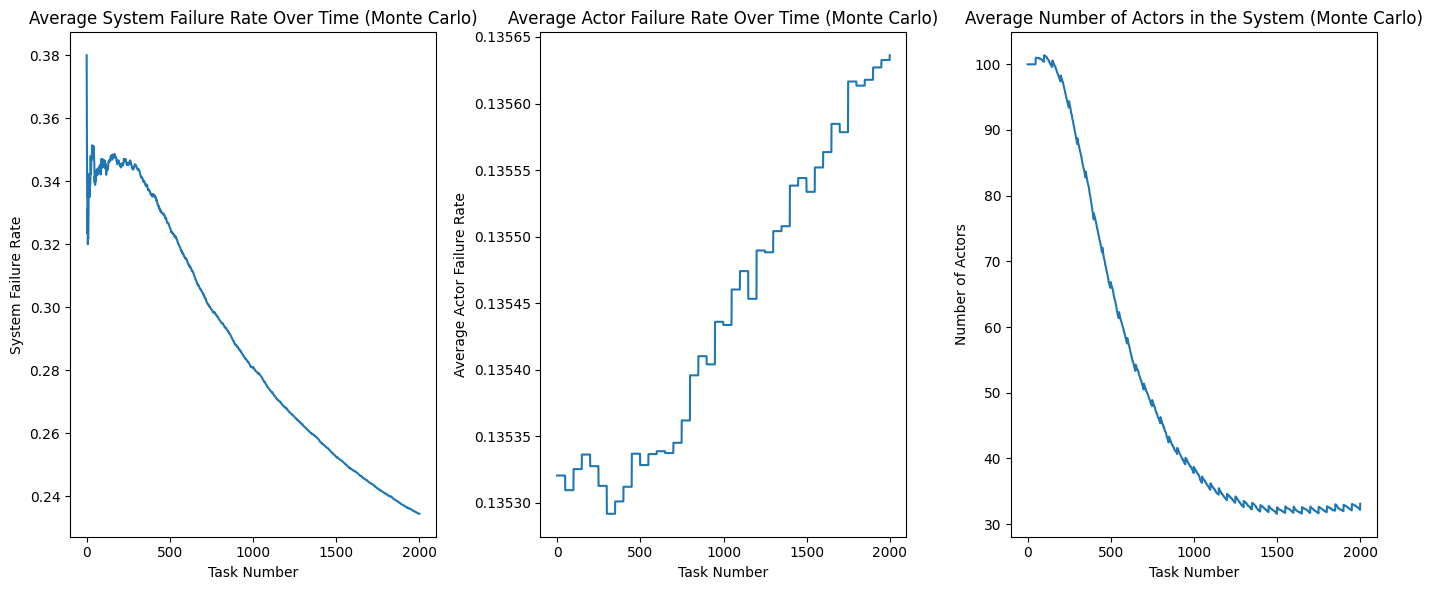

Average total successful tasks: 1519.98
Average total failed tasks: 463.84
Total number of actors: 140
Average final number of actors: 33.1
Uncompleted simulations: 1/50

Classification Metrics (Averaged over Monte Carlo runs):
Average Precision: 0.8633625534766511
Average Accuracy: -18.75342857142857
Average Recall: 0.06143330968832227


In [194]:
# Plot average reward and loss depending on failure rate
plt.figure(figsize=(10, 6))
plt.plot(list(average_rewards_per_bin.keys()), list(average_rewards_per_bin.values()), label='Average Reward')
plt.plot(list(average_losses_per_bin.keys()), list(average_losses_per_bin.values()), label='Average Loss')
plt.xlabel('Failure Rate')
plt.ylabel('Average Value')
plt.title('Average Reward and Loss depending on Failure Rate')
plt.legend()
plt.show()

# Plot aggregated results
plt.figure(figsize=(14, 6))

# Plot system failure rate over time (averaged over Monte Carlo runs)
plt.subplot(1, 3, 1)
plt.plot(avg_system_failure_rates)
plt.xlabel('Task Number')
plt.ylabel('System Failure Rate')
plt.title('Average System Failure Rate Over Time (Monte Carlo)')

# Plot average actor failure rate over time (averaged over Monte Carlo runs)
plt.subplot(1, 3, 2)
plt.plot(avg_average_failure_rates)
plt.xlabel('Task Number')
plt.ylabel('Average Actor Failure Rate')
plt.title('Average Actor Failure Rate Over Time (Monte Carlo)')

# Plot the number of actors in the system over time (averaged over Monte Carlo runs)
plt.subplot(1, 3, 3)
plt.plot(avg_actor_counts)
plt.xlabel('Task Number')
plt.ylabel('Number of Actors')
plt.title('Average Number of Actors in the System (Monte Carlo)')

plt.tight_layout()
plt.show()

# Final results
print(f'Average total successful tasks: {avg_final_successful_tasks}')
print(f'Average total failed tasks: {avg_final_failed_tasks}')
print(f'Total number of actors: {total_actors}')
print(f'Average final number of actors: {avg_final_number_of_actors}')
print(f'Uncompleted simulations: {uncompleted_simulations}/{MONTE_CARLO_RUNS}')

# Display precision, accuracy, and recall
print("\nClassification Metrics (Averaged over Monte Carlo runs):")
print(f'Average Precision: {avg_precision}')
print(f'Average Accuracy: {avg_accuracy}')
print(f'Average Recall: {avg_recall}')

# Add the ratio of failed tasks to the total number of tasks
# Find which average failure rate gives the best metrics
# Find out why it takes so long with low failure rate distributions

# Concerning simulation aborting because of everyone's ruin. It might be due to the small pool of actors with not enough actor having a low enough failure rate due to the random draw.

### No initial capital setup

In [195]:
N_ACTORS_INITIAL = 100  # Initial number of actors
N_ACTORS_TASK = 4  # Number of maximum actors for each task
N_TASKS = 300  # Number of tasks to simulate
SLASH_AMOUNT = 400  # Amount slashed for failed tasks
REWARD_AMOUNT = 100  # Reward for successful tasks
MONTE_CARLO_RUNS = 10  # Number of Monte Carlo simulations
BIN_SIZE = 0.05  # Size of the failure rate bins

# Monte Carlo results storage
monte_carlo_results = {
    'system_failure_rates': [],
    'average_failure_rates': [],
    'actor_counts': [],
    'final_successful_tasks': [],
    'final_failed_tasks': [],
    'precisions': [],
    'accuracies': [],
    'recalls': []
}

# Function to run a single simulation
def run_simulation(debt_evolution_bins):
    # Initialize actors and faulty sets
    actors = [Actor(i, 0) for i in range(N_ACTORS_INITIAL)]
    for actor in actors:
        faulty_set = FaultySet([actor], generate_p_fail())
        actor.failure_rate = faulty_set.p_fail
        faulty_sets.append(faulty_set)

    successful_tasks = 0
    failed_tasks = 0

    system_failure_rates = []
    actor_counts = []
    average_failure_rates = []

    # Task simulation loop
    for task_id in range(1, N_TASKS + 1):
        # Pick a random subset of actors for the task
        task_actors = random.sample(actors, random.randint(2, N_ACTORS_TASK))
        
        # Check for faulty subsets within the chosen actors
        task_failed = False
        for faulty_set in faulty_sets:
            if set(faulty_set.actors).issubset(task_actors):
                if random.random() < faulty_set.p_fail:
                    task_failed = True
                    break

        if task_failed:
            failed_tasks += 1
            for actor in task_actors:
                actor.stake -= SLASH_AMOUNT
        else:
            successful_tasks += 1
            for actor in task_actors:
                actor.stake += REWARD_AMOUNT
        
        # Track system evolution metrics
        system_failure_rate = failed_tasks / task_id
        average_failure_rate = np.mean([fs.p_fail for fs in faulty_sets])
        
        system_failure_rates.append(system_failure_rate)
        average_failure_rates.append(average_failure_rate)
        actor_counts.append(len(actors))

        for actor in actors:
            debt_evolution_bins[get_failure_rate_bin(actor.failure_rate, BIN_SIZE)][task_id-1].append(actor.stake)
    
    return {
        'system_failure_rates': system_failure_rates,
        'average_failure_rates': average_failure_rates,
        'actor_counts': actor_counts,
        'successful_tasks': successful_tasks,
        'failed_tasks': failed_tasks
    }

debt_evolution_bins = {round(i * BIN_SIZE, 2): [[] for _ in range(N_TASKS)] for i in range(int(1/BIN_SIZE))}  # Bins of BIN_SIZE

# Run Monte Carlo simulations
for i in range(MONTE_CARLO_RUNS):
    print(f'Running Monte Carlo simulation {i + 1}/{MONTE_CARLO_RUNS}...')
    result = run_simulation(debt_evolution_bins)
    monte_carlo_results['system_failure_rates'].append(result['system_failure_rates'])
    monte_carlo_results['average_failure_rates'].append(result['average_failure_rates'])
    monte_carlo_results['actor_counts'].append(result['actor_counts'])
    monte_carlo_results['final_successful_tasks'].append(result['successful_tasks'])
    monte_carlo_results['final_failed_tasks'].append(result['failed_tasks'])

# Compute the average debt evolution for actors, grouped by failure rate bins
avg_debt_evolution_per_bin = {round(i * BIN_SIZE, 2): [] for i in range(int(1/BIN_SIZE))}
for bin_index, debt_evolution in debt_evolution_bins.items():
    avg_debt_evolution_per_bin[bin_index] = np.mean(debt_evolution, axis=1)

Running Monte Carlo simulation 1/10...
Running Monte Carlo simulation 2/10...
Running Monte Carlo simulation 3/10...
Running Monte Carlo simulation 4/10...
Running Monte Carlo simulation 5/10...
Running Monte Carlo simulation 6/10...
Running Monte Carlo simulation 7/10...
Running Monte Carlo simulation 8/10...
Running Monte Carlo simulation 9/10...
Running Monte Carlo simulation 10/10...


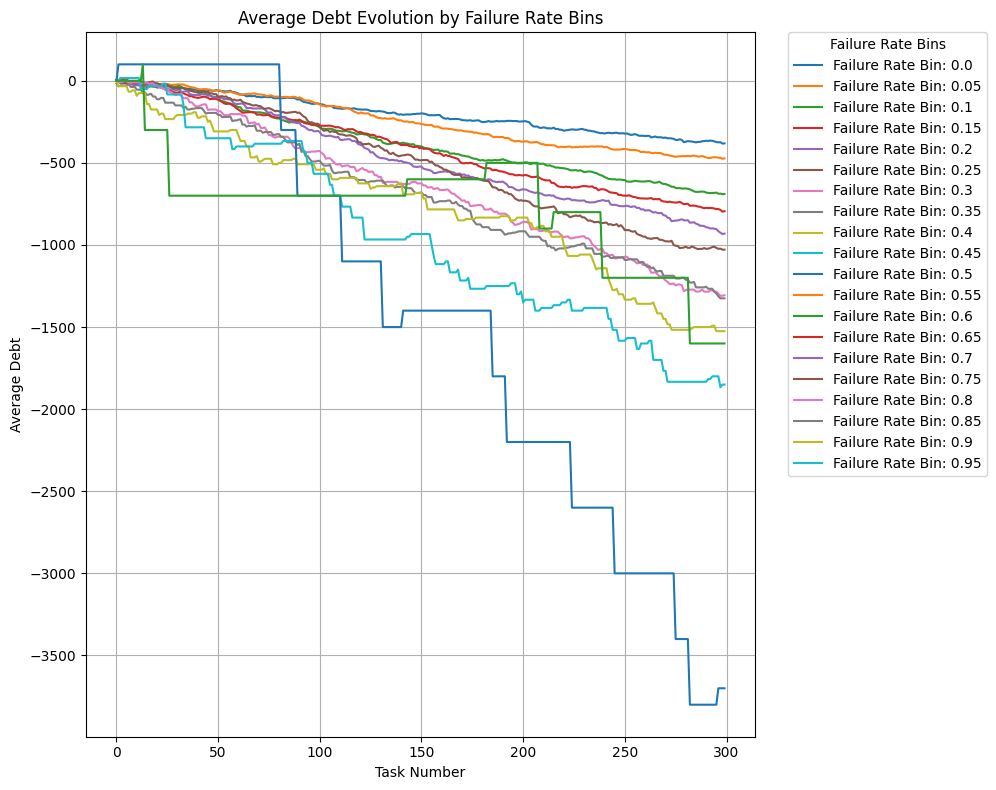

Average total successful tasks: 199.8
Average total failed tasks: 100.2


In [196]:
plt.figure(figsize=(12, 8))  # Increased figure size to accommodate legend
for bin_index, debt_evolution in avg_debt_evolution_per_bin.items():
    plt.plot(debt_evolution, label=f'Failure Rate Bin: {bin_index}')
plt.xlabel('Task Number')
plt.ylabel('Average Debt')
plt.title('Average Debt Evolution by Failure Rate Bins')
plt.legend(title='Failure Rate Bins', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make space for the legend
plt.show()

# Final results
print(f'Average total successful tasks: {np.mean(monte_carlo_results["final_successful_tasks"])}')
print(f'Average total failed tasks: {np.mean(monte_carlo_results["final_failed_tasks"])}')

# Essaier de faire ça en fonction du nombre de tâche effectué PAR L'ACTEUR

### Per Actor Loss

Running Monte Carlo simulation 1/10...
Running Monte Carlo simulation 2/10...
Running Monte Carlo simulation 3/10...
Running Monte Carlo simulation 4/10...
Running Monte Carlo simulation 5/10...
Running Monte Carlo simulation 6/10...
Running Monte Carlo simulation 7/10...
Running Monte Carlo simulation 8/10...
Running Monte Carlo simulation 9/10...
Running Monte Carlo simulation 10/10...


/tmp/ipykernel_7047/2792197679.py:122: RuntimeWarning: Mean of empty slice
  average_loss_per_task_per_bin[bin_key] = np.nanmean(padded_losses, axis=0)


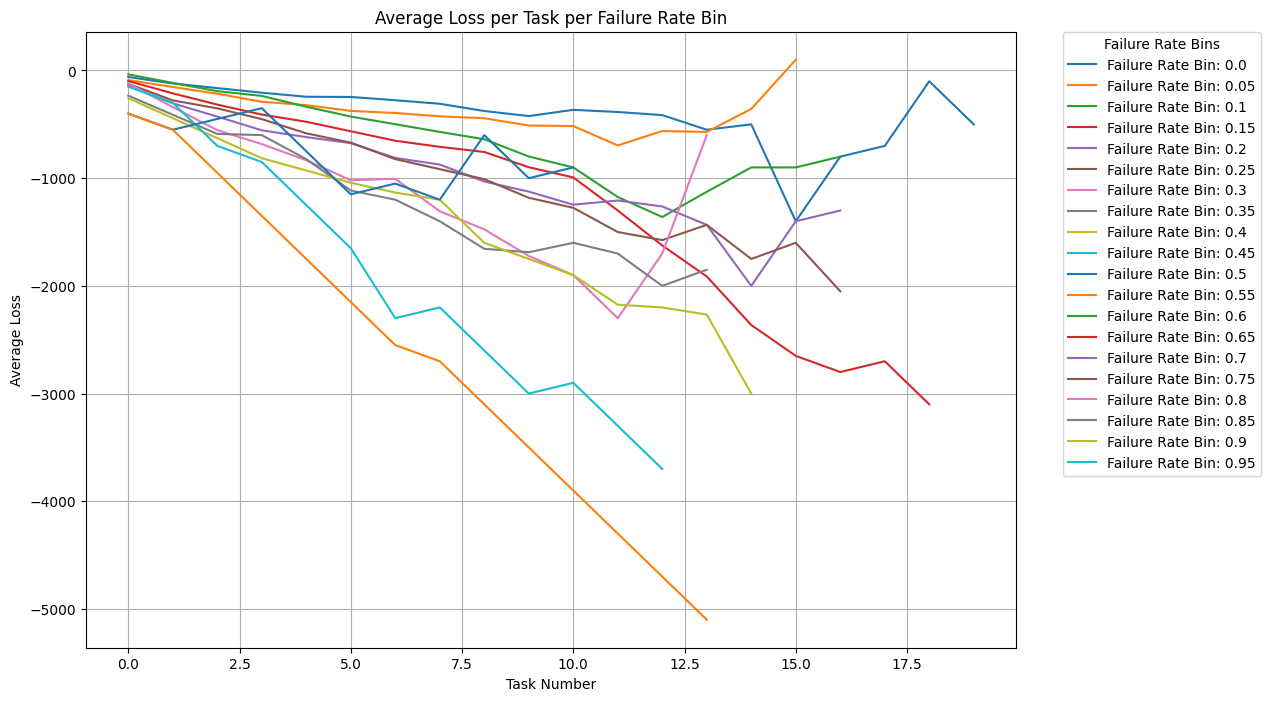

In [211]:
N_ACTORS_INITIAL = 100  # Initial number of actors
N_ACTORS_TASK = 4  # Number of maximum actors for each task
N_TASKS = 300  # Number of tasks to simulate
SLASH_AMOUNT = 400  # Amount slashed for failed tasks
REWARD_AMOUNT = 100  # Reward for successful tasks
MONTE_CARLO_RUNS = 10  # Number of Monte Carlo simulations
BIN_SIZE = 0.05  # Size of the failure rate bins

# Monte Carlo results storage
monte_carlo_results = {
    'system_failure_rates': [],
    'average_failure_rates': [],
    'actor_counts': [],
    'final_successful_tasks': [],
    'final_failed_tasks': [],
    'precisions': [],
    'accuracies': [],
    'recalls': [],
    'actors': []  # New dictionary to track losses per actor per task
}

# Actor class to track individual performance
class Actor:
    def __init__(self, id, stake):
        self.id = id
        self.stake = stake
        self.failure_rate = 0
        self.task_losses = []  # List to store loss for each task

# Function to run a single simulation
def run_simulation():
    # Initialize actors and faulty sets
    actors = [Actor(i, 0) for i in range(N_ACTORS_INITIAL)]
    for actor in actors:
        faulty_set = FaultySet([actor], generate_p_fail())
        actor.failure_rate = faulty_set.p_fail
        faulty_sets.append(faulty_set)

    successful_tasks = 0
    failed_tasks = 0

    system_failure_rates = []
    actor_counts = []
    average_failure_rates = []

    # Task simulation loop
    for task_id in range(1, N_TASKS + 1):
        # Pick a random subset of actors for the task
        task_actors = random.sample(actors, random.randint(2, N_ACTORS_TASK))
        
        # Check for faulty subsets within the chosen actors
        task_failed = False
        for faulty_set in faulty_sets:
            if set(faulty_set.actors).issubset(task_actors):
                if random.random() < faulty_set.p_fail:
                    task_failed = True
                    break

        if task_failed:
            failed_tasks += 1
            for actor in task_actors:
                actor.stake -= SLASH_AMOUNT
                # Append the new loss. Initialize with 0 if this is the first task.
                previous_loss = actor.task_losses[-1] if actor.task_losses else 0
                actor.task_losses.append(previous_loss-SLASH_AMOUNT)  # Record loss per task
        else:
            successful_tasks += 1
            for actor in task_actors:
                actor.stake += REWARD_AMOUNT
                # Append the new loss. Initialize with 0 if this is the first task.
                previous_loss = actor.task_losses[-1] if actor.task_losses else 0
                actor.task_losses.append(previous_loss+REWARD_AMOUNT)  # Record reward per task
        
        # Track system evolution metrics
        system_failure_rate = failed_tasks / task_id
        average_failure_rate = np.mean([fs.p_fail for fs in faulty_sets])
        
        system_failure_rates.append(system_failure_rate)
        average_failure_rates.append(average_failure_rate)
        actor_counts.append(len(actors))
    
    return {
        'system_failure_rates': system_failure_rates,
        'average_failure_rates': average_failure_rates,
        'actor_counts': actor_counts,
        'successful_tasks': successful_tasks,
        'failed_tasks': failed_tasks,
        'actors': actors
    }

# Run Monte Carlo simulations
for i in range(MONTE_CARLO_RUNS):
    print(f'Running Monte Carlo simulation {i + 1}/{MONTE_CARLO_RUNS}...')
    result = run_simulation()
    monte_carlo_results['system_failure_rates'].append(result['system_failure_rates'])
    monte_carlo_results['average_failure_rates'].append(result['average_failure_rates'])
    monte_carlo_results['actor_counts'].append(result['actor_counts'])
    monte_carlo_results['final_successful_tasks'].append(result['successful_tasks'])
    monte_carlo_results['final_failed_tasks'].append(result['failed_tasks'])
    monte_carlo_results['actors'].append(result['actors'])  # Store the losses per actor

# Create structure to store loss per task per bin
loss_per_task = {round(i * BIN_SIZE, 2): [] for i in range(int(1 / BIN_SIZE))}
# Iterate over Monte Carlo runs to bin actor losses
for run in monte_carlo_results['actors']:
    for actor in run:
        bin_key = get_failure_rate_bin(actor.failure_rate, BIN_SIZE)
        actor_losses = actor.task_losses
        
        # Pad the losses with `None` to ensure consistent task lengths
        if len(actor_losses) < N_TASKS:
            actor_losses += [None] * (N_TASKS - len(actor_losses))  # Pad with `None`
        
        loss_per_task[bin_key].append(actor_losses)

# Compute the average loss per task per bin, skipping `None` values
average_loss_per_task_per_bin = {}
for bin_key, losses in loss_per_task.items():
    # Convert `None` values to `np.nan` for handling in numpy
    padded_losses = np.array([[np.nan if loss is None else loss for loss in actor_losses] for actor_losses in losses])
    # Compute the average while ignoring `np.nan`
    average_loss_per_task_per_bin[bin_key] = np.nanmean(padded_losses, axis=0)

# Plot the average loss per task per bin
plt.figure(figsize=(12, 8))
for bin_key, losses in average_loss_per_task_per_bin.items():
    plt.plot(losses, label=f'Failure Rate Bin: {bin_key}')
plt.xlabel('Task Number')
plt.ylabel('Average Loss')
plt.title('Average Loss per Task per Failure Rate Bin')
plt.legend(title='Failure Rate Bins', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.show()